## Ray: Task Programming with Remote Functions

> to install Ray run
```
  conda install pip
  pip install ray
```

So far we have looked at cloud programming tools geared towards data parallel applications driven by a data decomposition. But, as well recall from Chapter 2 of Mattson, there is also a task decomposition. Data decomposition matches the data science, groupby analysis workloads of Internet/cloud data processing, such as processing logs, crawling and indexing the Web. However, "modern AI" applications have different demands.

The paper [Ray: A Distributed Framework for Emerging AI Applications](https://arxiv.org/pdf/1712.05889.pdf) takes a different approach. The abstract is confusing:

> The next generation of AI applications will continuously
interact with the environment and learn from these interactions. These applications impose new and demanding
systems requirements, both in terms of performance and
flexibility. In this paper, we consider these requirements
and present Ray—a distributed system to address them.
Ray implements a unified interface that can express both
task-parallel and actor-based computations, supported by
a single dynamic execution engine. To meet the performance requirements, Ray employs a distributed scheduler
and a distributed and fault-tolerant store to manage the
system’s control state.

All one really gets out of this is that it is a distributed task/actor programming model. IMO, this is an example of poor, underspecific writing. My statement on Ray is that:

  > RB: Data parallel frameworks, such as Dask and Spark, do not capture the task/actor decomposition needed to encode parallelism for modern AI applications.
  
OK, that's not perfect either. As we dig into the paper, we find more specific statements that shed light on the issues:

> They must aim not only to exploit the data gathered, but also to explore the space of possible actions. 

> These characteristics drive new systems requirements:
a system for RL must support fine-grained computations
(e.g., rendering actions in milliseconds when interacting
with the real world, and performing vast numbers of simulations), must support heterogeneity both in time (e.g.,
a simulation may take milliseconds or hours) and in resource usage (e.g., GPUs for training and CPUs for simulations), and must support dynamic execution, as results of simulations or interactions with the environment can change future computations.

The paper uses reinforcement learning as the singular motivation. It's a good and important example. However, the generality of the framework does not match the specificity of the motivating application. 

### Remote Functions

These are simple examples take from the [Ray tutorial](https://github.com/ray-project/tutorial).

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import ray
import time

print('Successfully imported ray!')

ImportError: dlopen(/Users/randal/opt/anaconda3/envs/pp/lib/python3.10/site-packages/grpc/_cython/cygrpc.cpython-310-darwin.so, 0x0002): tried: '/Users/randal/opt/anaconda3/envs/pp/lib/python3.10/site-packages/grpc/_cython/cygrpc.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have (arm64), need (x86_64)))

In [3]:
ray.init(num_cpus=4, ignore_reinit_error=True)

# Sleep a little to improve the accuracy of the timing measurements used below,
# because some workers may still be starting up in the background.
time.sleep(2.0)

Run a trivial program in serial to show that it is slow.

In [4]:
# A function simulating a more interesting computation that takes one second.
def slow_function(i):
    time.sleep(1)
    return i

start_time = time.time()

results = []
for i in range(4):
  results.append(slow_function(i))
  
duration = time.time() - start_time
print('Executing the for loop took {:.3f} seconds.'.format(duration))
print('The results are:', results)

Executing the for loop took 4.015 seconds.
The results are: [0, 1, 2, 3]


Parallelize the same computation with remote functions.

In [5]:
@ray.remote
def slow_function(i):
    time.sleep(1)
    return i

start_time = time.time()

results = []
oids = []

for i in range(4):
   oids.append(slow_function.remote(i))

for i in range(4):
   results.append(ray.get(oids[i]))
  
duration = time.time() - start_time
print('Executing the for loop took {:.3f} seconds.'.format(duration))
print('The results are:', results)

Executing the for loop took 1.032 seconds.
The results are: [0, 1, 2, 3]


Good. A trivially parallelizeable program has a speedup of 4-$\epsilon$ on four cores. Ray has some similarities to joblib. It creates functions that run asynchronously. The Ray specific items here are:
  * `@ray.remote` decorator that indicates that this is a remote function.
  * `slow_functions.remote(i)` invoke the function to run asynchronously 
  * `ray.get(oids[i])` get the return value of the remote function

Ray is a runtime system that is managing a cluster, just like Dask and Spark. Calling `.remote()` on a function sends it to the cluster for execution. Ray will package the entire function and all the data needed and send it to the executor.

You will also notice that this programming pattern is similar to the fork/join pattern used in Java threads, i.e. launch asynchronous executors and then join them serially. `ray.get()` awaits the completion of a remote function. The loop of `ray.get()` joins remote functions serially. It completes once all of the remote functions complete.

Ray functions are **stateless**. They take arguments and return something. Their operations has no side effects and there is no shared state.

### Remote function representation

`ray.remote()` returns an object identifier that is a handle to the function. The reference can be used to query and manipulate the remote function. We will see that references create the capability to build complex dependency chains. 

In [6]:
print(oids)

[ObjectRef(a67dc375e60ddd1affffffffffffffffffffffff0100000001000000), ObjectRef(63964fa4841d4a2effffffffffffffffffffffff0100000001000000), ObjectRef(69a6825d641b4613ffffffffffffffffffffffff0100000001000000), ObjectRef(ee4e90da584ab0ebffffffffffffffffffffffff0100000001000000)]


### Distributing Data to remote functions

Let's revisit our mutual outlinks example from joblib in Ray.

10099

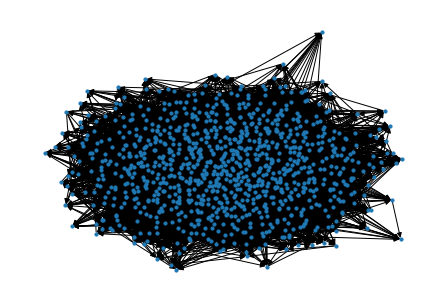

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
G= nx.erdos_renyi_graph(1000,0.01,directed=True)
nx.draw(G, pos=nx.spring_layout(G), node_size=10)
G.number_of_edges()

In [8]:
gmat = nx.to_numpy_matrix(G)

### Serial Reference Implementation

In [9]:
import numpy as np

gmat = nx.to_numpy_matrix(G)

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))
        
np.count_nonzero(outmat)

48626

### Ray `remote()` implementation and timing

We will do the dumbest thing, which will work. The remote function will refer to `gmat` as a global variable. Given that Ray is process based (not thread based) there is no shared memory and so Ray is doing something smart to make it work.

In [10]:
@ray.remote
def inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))    
    return partial_out
    
oids = []
results = []

for i in range(gmat.shape[0]):
    oids.append(inner_loop.remote(i))
    
for i in range(gmat.shape[0]):    
   results.append(ray.get(oids[i]))

outmat = np.array(results)
np.count_nonzero(outmat)

48626

In [11]:
%%timeit

oids = []
results = []

for i in range(gmat.shape[0]):
    oids.append(inner_loop.remote(i))
    
for i in range(gmat.shape[0]):    
   results.append(ray.get(oids[i]))

1.08 s ± 8.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


OK, let's compare the performance with joblib.

In [12]:
def inner_loopj(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))    
    return partial_out
    
from joblib import Parallel, delayed
partials = Parallel(n_jobs=4)(delayed(inner_loopj)(i) for i in range(gmat.shape[0]))

outmat = np.array(partials)
np.count_nonzero(outmat)

48626

In [14]:
%%timeit

partials = Parallel(n_jobs=4)(delayed(inner_loopj)(i) for i in range(gmat.shape[0]))

1.85 s ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


OK, so ray is a bunch faster.  Why?

### Ray Memory Management

Ray implements an object store for remote functions to share memory. Instead of copying data to each process, Ray puts into a an object store and let's the processes access them. This can either be Redis when functions are distributed across multiple nodes or in [Plasma](https://ray-project.github.io/2017/08/08/plasma-in-memory-object-store.html) which provides shared memory for processes on the same machine.

This is consistent with stateless functions. Ray is packaging the needed data (global variables) and sending them to the functions. Not surprisingly, this data must be read only.

We can make Ray really slow by making it copy memory, passing the whole array as a function argument. 

In [18]:
@ray.remote
def inner_loop2(i, gmat):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))    
    return partial_out
    
oids = []
results = []

for i in range(gmat.shape[0]):
    oids.append(inner_loop2.remote(i, gmat))
    
for i in range(gmat.shape[0]):    
   results.append(ray.get(oids[i]))

outmat = np.array(results)
np.count_nonzero(outmat)

48626

In [19]:
%%timeit

oids = []
results = []

for i in range(gmat.shape[0]):
    oids.append(inner_loop2.remote(i,gmat))
    
for i in range(gmat.shape[0]):    
   results.append(ray.get(oids[i]))

(inner_loop2 pid=37795) 
(inner_loop2 pid=37794) 
6.4 s ± 28.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can replicate Ray's performance of handling global variables by put the matrix into the object store. This is `ray.put()`

In [20]:
@ray.remote
def inner_loop3(i, gmat_ref):
    gmat = ray.get(gmat_ref)
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))    
    return partial_out

gmat_ref = ray.put(gmat)
print(gmat_ref)

oids = []
results = []

for i in range(gmat.shape[0]):
    oids.append(inner_loop2.remote(i, gmat_ref))
    
for i in range(gmat.shape[0]):    
   results.append(ray.get(oids[i]))
                  
outmat = np.array(results)
np.count_nonzero(outmat)

ObjectRef(ffffffffffffffffffffffffffffffffffffffff0100000029230000)
(inner_loop2 pid=37794) 


48626

In [21]:
%%timeit

oids = []
results = []

for i in range(gmat.shape[0]):
    oids.append(inner_loop2.remote(i,gmat_ref))
    
for i in range(gmat.shape[0]):    
   results.append(ray.get(oids[i]))

(inner_loop2 pid=37795) 
1.3 s ± 5.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It turns out that in remote functions you can use Ray objects as if they were function arguments. This has the same performance. It makes programming a little easier. 

In [22]:
@ray.remote
def inner_loop3(i, gmat):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))    
    return partial_out

gmat_ref = ray.put(gmat)

oids = []
results = []

for i in range(gmat.shape[0]):
    oids.append(inner_loop2.remote(i, gmat_ref))
    
for i in range(gmat.shape[0]):    
   results.append(ray.get(oids[i]))
                  
outmat = np.array(results)
np.count_nonzero(outmat)

48626

In [24]:
%%timeit

oids = []
results = []

for i in range(gmat.shape[0]):
    oids.append(inner_loop3.remote(i,gmat_ref))
    
for i in range(gmat.shape[0]):    
   results.append(ray.get(oids[i]))

(inner_loop3 pid=37794) 
(inner_loop3 pid=37796) 
(inner_loop3 pid=37796) 
(inner_loop3 pid=37795) 
(inner_loop3 pid=37794) 
1.3 s ± 9.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


If we compare this implementation to the slow implementation.  This is a _pass by reference_ and the slow one is _pass by value_.

Overall, it's pretty cool that Ray will take global variables that are using in functions and transparently marshall them into an object store.

* Ray serializes/deserializes objects, giving the appearance of shared memory.
    * the shared memory abstraction for global variables is both good and bad.
    * _good_: makes programming easy. prevents 
    * _bad_ : implicit data movement makes performance opaque

## Outcomes

  * Ray is built on distributed objects
  * Ray has a `put()` and `get()` interface for objects that can be functions or data
      * `get()` on a remote function waits for completion and fetches its return values
  * The `ray.remote` decorator makes a function suitable for parallel execution
  * The `remote()` call starts asynchronous execution of a function.
  